## Problem Definition
Target: Predict Final_Price (Regression) using smartphone specs.
## Load Dataset and Basic Inspection
Output: head/tail, shape, info, missing values.


In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly

In [203]:
FILE_PATH = 'smartphones.csv'
df = pd.read_csv(FILE_PATH)
df

,Smartphone,Brand,Model,RAM,Storage,Color,Free,Final Price
0,Realme C55 8/256GB Sunshower Libre,Realme,C55,8.0,256.0,Yellow,Yes,231.60
1,Samsung Galaxy M23 5G 4/128GB Azul Libre,Samsung,Galaxy M23,4.0,128.0,Blue,Yes,279.00
2,Motorola Moto G13 4/128GB Azul Lavanda Libre,Motorola,Moto G13,4.0,128.0,Blue,Yes,179.01
3,Xiaomi Redmi Note 11S 6/128GB Gris Libre,Xiaomi,Redmi Note 11S,6.0,128.0,Gray,Yes,279.99
4,Nothing Phone (2) 12/512GB Blanco Libre,Nothing,Phone (2),12.0,512.0,White,Yes,799.00
...,...,...,...,...,...,...,...,...
1811,Xiaomi Redmi Note 8 4/64GB Azul Libre,Xiaomi,Redmi Note 8,4.0,64.0,Blue,Yes,249.01
1812,Xiaomi Redmi Note 8T 4/128GB Azul Estelar Libre,Xiaomi,Redmi Note 8T,4.0,128.0,Blue,Yes,200.00
1813,Xiaomi Redmi Note 9 4/128GB Blanco Libre,Xiaomi,Redmi Note 9,4.0,128.0,White,Yes,269.00
1814,Xiaomi Redmi Note 9S 4/64GB Dual SIM Gris Libre,Xiaomi,Note 9S,4.0,64.0,Gray,Yes,211.00


In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816 entries, 0 to 1815
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Smartphone   1816 non-null   object 
 1   Brand        1816 non-null   object 
 2   Model        1816 non-null   object 
 3   RAM          1333 non-null   float64
 4   Storage      1791 non-null   float64
 5   Color        1816 non-null   object 
 6   Free         1816 non-null   object 
 7   Final Price  1816 non-null   float64
dtypes: float64(3), object(5)
memory usage: 113.6+ KB


In [205]:
df.isna().sum() ##b Check missing values

Smartphone       0
Brand            0
Model            0
RAM            483
Storage         25
Color            0
Free             0
Final Price      0
dtype: int64

In [206]:
df.describe(include='all')

,Smartphone,Brand,Model,RAM,Storage,Color,Free,Final Price
count,1816,1816,1816,1333.00000,1791.000000,1816,1816,1816.000000
unique,1816,37,383,NaN,NaN,17,2,NaN
top,Realme C55 8/256GB Sunshower Libre,Samsung,iPhone 13,NaN,NaN,Black,Yes,NaN
freq,1,458,60,NaN,NaN,537,1772,NaN
mean,NaN,NaN,NaN,5.96099,162.652150,NaN,NaN,492.175573
std,NaN,NaN,NaN,2.66807,139.411605,NaN,NaN,398.606183
min,NaN,NaN,NaN,1.00000,2.000000,NaN,NaN,60.460000
25%,NaN,NaN,NaN,4.00000,64.000000,NaN,NaN,200.990000
50%,NaN,NaN,NaN,6.00000,128.000000,NaN,NaN,349.990000
75%,NaN,NaN,NaN,8.00000,256.000000,NaN,NaN,652.717500


In [207]:
# Clean column names
df.columns = [c.strip().replace(" ", "_") for c in df.columns]
df.columns


Index(['Smartphone', 'Brand', 'Model', 'RAM', 'Storage', 'Color', 'Free',
       'Final_Price'],
      dtype='object')

## Handling Missing Values (Before EDA)

I first handle missing values so that my plots and later machine learning steps do not break due to `NaN` values.  
From the dataset, only `RAM` and `Storage` contain missing values, so I impute:
- Numeric (`RAM`, `Storage`) → median (robust to outliers)
- Categorical (`Brand`, `Model`, `Color`, `Free`) → most frequent (keeps valid categories)

I apply this using a scikit-learn pipeline to ensure consistent preprocessing.


In [208]:
# ===== Handling Missing Values (Before EDA) =====

import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Check missing values
df.isna().sum()

# Columns
num_cols = ["RAM", "Storage"]
cat_cols = ["Brand", "Model", "Color", "Free"]

# Pipelines
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Preprocessor
preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ]
)

preprocess


,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


## Exploratory Data Analysis (EDA)
Purpose: Understand target distribution, outliers, and feature-price relationships.
Outputs: histogram, boxplot, scatterplots, heatmap.
Histogram (Final_Price) → shows the price distribution is right-skewed (many cheaper phones, fewer expensive ones).


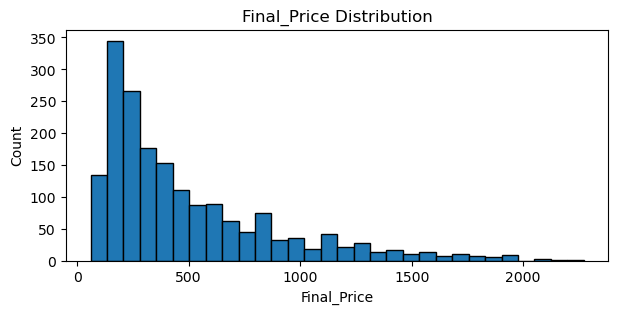

In [209]:
# Histogram of Final_Price
import matplotlib.pyplot as plt

plt.figure(figsize=(7,3))
plt.hist(df["Final_Price"], bins=30, edgecolor="black")
plt.title("Final_Price Distribution")
plt.xlabel("Final_Price")
plt.ylabel("Count")
plt.show()


Boxplot (Final_Price) → shows outliers (very expensive phones).

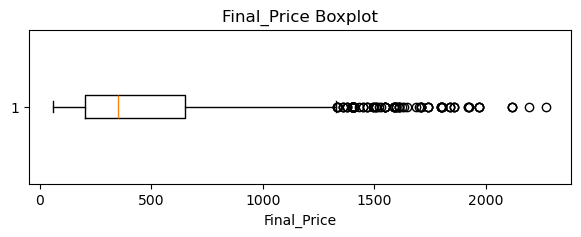

In [210]:
# Boxplot of Final_Price
plt.figure(figsize=(7,2))
plt.boxplot(df["Final_Price"], vert=False)
plt.title("Final_Price Boxplot")
plt.xlabel("Final_Price")
plt.show()


Scatter (RAM vs Final_Price) and Scatter (Storage vs Final_Price) → shows both have a positive relationship with price (good predictors)

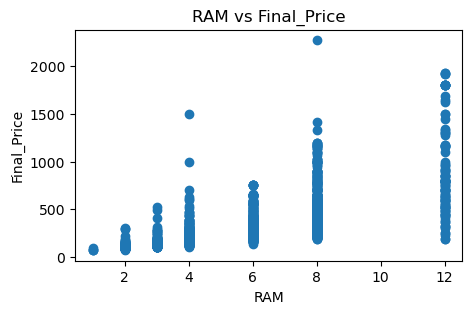

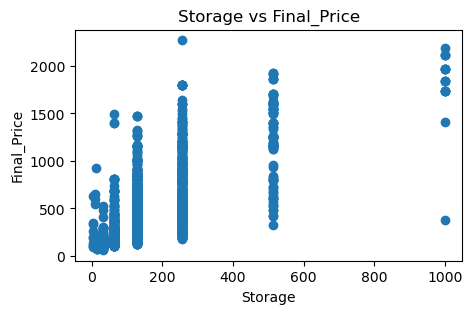

In [211]:
# Scatter plots of Final_Price against RAM and Storage
plt.figure(figsize=(5,3))
plt.scatter(df["RAM"], df["Final_Price"])
plt.title("RAM vs Final_Price")
plt.xlabel("RAM")
plt.ylabel("Final_Price")
plt.show()

plt.figure(figsize=(5,3))
plt.scatter(df["Storage"], df["Final_Price"])
plt.title("Storage vs Final_Price")
plt.xlabel("Storage")
plt.ylabel("Final_Price")
plt.show()


Correlation heatmap → confirms RAM/Storage correlate with price and with each other

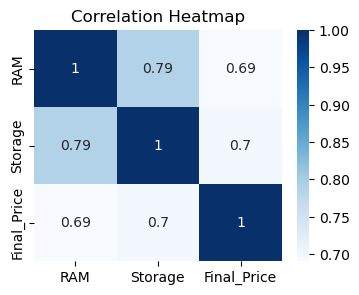

In [212]:
# Correlation heatmap
import seaborn as sns

corr = df[["RAM", "Storage", "Final_Price"]].corr(numeric_only=True)
plt.figure(figsize=(4,3))
sns.heatmap(corr, annot=True, cmap="Blues")
plt.title("Correlation Heatmap")
plt.show()


## Train-Test Split + Baseline Model 
1) I define my features (X) using smartphone specs (`Brand`, `Model`, `RAM`, `Storage`, `Color`, `Free`) and set y as `Final_Price`.
2) I split the data into training and testing sets so I can evaluate performance on unseen data.
3) I train a baseline regression model (Linear Regression) using a scikit-learn Pipeline (preprocessing + model).
4) I evaluate the baseline model using MAE and RMSE to establish a benchmark for later comparisons with other models, feature engineering, and hyperparameter tuning.


In [213]:
# Define X and y
X = df[["Brand", "Model", "RAM", "Storage", "Color", "Free"]].copy()
y = df["Final_Price"].copy()

X.head(3)

,Brand,Model,RAM,Storage,Color,Free
0,Realme,C55,8.0,256.0,Yellow,Yes
1,Samsung,Galaxy M23,4.0,128.0,Blue,Yes
2,Motorola,Moto G13,4.0,128.0,Blue,Yes


In [214]:
#Train-test split 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (1452, 6) Test: (364, 6)


In [215]:
#Baseline model (LinearRegression) + Evaluation
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

baseline_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

baseline_pipe.fit(X_train, y_train)
pred_base = baseline_pipe.predict(X_test)

mae_base = mean_absolute_error(y_test, pred_base)
rmse_base = np.sqrt(mean_squared_error(y_test, pred_base))

results_base = pd.DataFrame([{
    "Model": "LinearRegression (Baseline)",
    "MAE": mae_base,
    "RMSE": rmse_base
}])

results_base


,Model,MAE,RMSE
0,LinearRegression (Baseline),116.776936,183.958763


## Step 9: Base Model vs Other Models (Model Comparison)

In this step, I compare my baseline regression model with other regression algorithms to identify which model predicts `Final_Price` most accurately.
- I use the same train-test split and the same preprocessing pipeline for every model to ensure the comparison is fair.
- I evaluate each model using MAE and RMSE 
- The model with the lowest RMSE will be selected as the best candidate for my feature engineering and hyperparameter tuning.


In [216]:
# Base model vs other models 

import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(random_state=42),
    "RandomForest": RandomForestRegressor(random_state=42, n_estimators=200),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
}

results_compare = []

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))

    results_compare.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse
    })

results_compare = pd.DataFrame(results_compare).sort_values("RMSE")
results_compare


,Model,MAE,RMSE
0,LinearRegression,116.776936,183.958763
1,Ridge,126.220644,193.292663
2,RandomForest,117.900177,196.916968
3,GradientBoosting,140.724179,207.858418


## Select Best Model

From the model comparison results, LinearRegression has the lowest RMSE and MAE.
Therefore, LinearRegression is selected as the **current best model** to continue with feature engineering.

Next, I test whether feature engineering improves this best model by comparing:
**LinearRegression (before feature engineering)** vs **LinearRegression (after feature engineering)** using the same evaluation metrics.


In [217]:
# Select best model 
best_model_name = results_compare.iloc[0]["Model"]
best_model_name


'LinearRegression'

In [218]:
# Feature engineering

df_fe = df.copy()

# 1) Convert Free (Yes/No) -> numeric 1/0
df_fe["Free_bin"] = df_fe["Free"].astype(str).str.strip().str.lower().map({"yes": 1, "no": 0})

# 2) Interaction feature: RAM * Storage (combined effect)
df_fe["RAM_x_Storage"] = df_fe["RAM"] * df_fe["Storage"]

# 3) Ratio feature: Storage per RAM (value/performance style indicator)
df_fe["Storage_per_RAM"] = df_fe["Storage"] / df_fe["RAM"]

df_fe[["Free", "Free_bin", "RAM", "Storage", "RAM_x_Storage", "Storage_per_RAM"]].head()


,Free,Free_bin,RAM,Storage,RAM_x_Storage,Storage_per_RAM
0,Yes,1,8.0,256.0,2048.0,32.000000
1,Yes,1,4.0,128.0,512.0,32.000000
2,Yes,1,4.0,128.0,512.0,32.000000
3,Yes,1,6.0,128.0,768.0,21.333333
4,Yes,1,12.0,512.0,6144.0,42.666667


In [219]:
# Compare best model before vs after feature engineering

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

y = df_fe["Final_Price"]

# BEFORE feature engineering
X_before = df_fe[["Brand", "Model", "RAM", "Storage", "Color", "Free"]]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_before, y, test_size=0.2, random_state=42
)

num_cols_b = ["RAM", "Storage"]
cat_cols_b = ["Brand", "Model", "Color", "Free"]

preprocess_before = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_cols_b),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols_b),
    ]
)

pipe_before = Pipeline(steps=[
    ("preprocess", preprocess_before),
    ("model", LinearRegression())
])

pipe_before.fit(X_train_b, y_train_b)
pred_before = pipe_before.predict(X_test_b)

mae_before = mean_absolute_error(y_test_b, pred_before)
rmse_before = np.sqrt(mean_squared_error(y_test_b, pred_before))

# AFTER feature engineering
X_after = df_fe[[
    "Brand", "Model", "RAM", "Storage", "Color", "Free",
    "Free_bin", "RAM_x_Storage", "Storage_per_RAM"
]]

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(
    X_after, y, test_size=0.2, random_state=42
)

num_cols_a = ["RAM", "Storage", "Free_bin", "RAM_x_Storage", "Storage_per_RAM"]
cat_cols_a = ["Brand", "Model", "Color", "Free"]

preprocess_after = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_cols_a),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols_a),
    ]
)

pipe_after = Pipeline(steps=[
    ("preprocess", preprocess_after),
    ("model", LinearRegression())
])

pipe_after.fit(X_train_a, y_train_a)
pred_after = pipe_after.predict(X_test_a)

mae_after = mean_absolute_error(y_test_a, pred_after)
rmse_after = np.sqrt(mean_squared_error(y_test_a, pred_after))

# Results table
results_fe = pd.DataFrame([
    {"Stage": "Before Feature Engineering", "Model": "LinearRegression", "MAE": mae_before, "RMSE": rmse_before},
    {"Stage": "After Feature Engineering",  "Model": "LinearRegression", "MAE": mae_after,  "RMSE": rmse_after},
]).sort_values("RMSE")

results_fe


,Stage,Model,MAE,RMSE
1,After Feature Engineering,LinearRegression,115.804092,182.129092
0,Before Feature Engineering,LinearRegression,116.776936,183.958763


## Model Comparison After Feature Engineering

After adding engineered features, I re-train and evaluate multiple regression models again using the same engineered dataset and preprocessing pipeline.

This step is needed because feature engineering can change which model performs best.  
I compare models fairly using the same train-test split and the same preprocessing, and evaluate them with MAE and RMSE.  
The best-performing model will be selected for hyperparameter tuning.


In [220]:
# Compare models AFTER Feature Engineering (Engineered Dataset)

import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

models_fe = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(random_state=42),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
}

rows = []

for name, model in models_fe.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocess_after),
        ("model", model)
    ])

    pipe.fit(X_train_a, y_train_a)
    pred = pipe.predict(X_test_a)

    mae = mean_absolute_error(y_test_a, pred)
    rmse = np.sqrt(mean_squared_error(y_test_a, pred))

    rows.append({"Model": name, "MAE": mae, "RMSE": rmse})

results_compare_fe = pd.DataFrame(rows).sort_values("RMSE")
results_compare_fe


,Model,MAE,RMSE
0,LinearRegression,115.804092,182.129092
2,RandomForest,117.608885,196.599633
3,GradientBoosting,139.810925,205.578239
1,Ridge,145.549981,215.247625


In [221]:
# Hyperparameter tuning on BEST model after FE

from sklearn.model_selection import RandomizedSearchCV

best_model_name_fe = results_compare_fe.iloc[0]["Model"]
best_model_name_fe


'LinearRegression'

## Hyperparameter Tuning (Before vs After Tuning)

From the model comparison after feature engineering, LinearRegression achieved the lowest RMSE.
However, LinearRegression has no meaningful hyperparameters to tune.

I tune the best-performing model (after feature engineering) that has tunable hyperparameters: RandomForestRegressor.

I use RandomizedSearchCV and evaluate using RMSE and MAE.
Then I compare:
- RandomForest (Before Tuning) vs RandomForest (After Tuning)

This shows whether tuning improves the model on the same engineered dataset.


In [222]:
# Hyperparameter tuning (RandomForest)

import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

# RandomForest baseline (Before Tuning)
rf_base = Pipeline(steps=[
    ("preprocess", preprocess_after),
    ("model", RandomForestRegressor(random_state=42))
])

rf_base.fit(X_train_a, y_train_a)
pred_rf_base = rf_base.predict(X_test_a)

mae_rf_before = mean_absolute_error(y_test_a, pred_rf_base)
rmse_rf_before = np.sqrt(mean_squared_error(y_test_a, pred_rf_base))

# RandomizedSearchCV (Tuning)
param_dist = {
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
}

rf_search = RandomizedSearchCV(
    estimator=Pipeline(steps=[
        ("preprocess", preprocess_after),
        ("model", RandomForestRegressor(random_state=42))
    ]),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring="neg_root_mean_squared_error",
    random_state=42,
    n_jobs=-1
)

rf_search.fit(X_train_a, y_train_a)

rf_best = rf_search.best_estimator_
pred_rf_tuned = rf_best.predict(X_test_a)

mae_rf_after = mean_absolute_error(y_test_a, pred_rf_tuned)
rmse_rf_after = np.sqrt(mean_squared_error(y_test_a, pred_rf_tuned))

# Comparison table (Before vs After Tuning)
results_rf_tuning = pd.DataFrame([
    {"Stage": "RandomForest (Before Tuning)", "MAE": mae_rf_before, "RMSE": rmse_rf_before},
    {"Stage": "RandomForest (After Tuning)",  "MAE": mae_rf_after,  "RMSE": rmse_rf_after},
]).sort_values("RMSE")

rf_search.best_params_, results_rf_tuning


({'model__n_estimators': 400,
  'model__min_samples_split': 5,
  'model__min_samples_leaf': 1,
  'model__max_depth': None},
                           Stage         MAE        RMSE
 1   RandomForest (After Tuning)  115.850737  193.694794
 0  RandomForest (Before Tuning)  117.608885  196.599633)

## Final Model Selection and Saving the Model

Based on the comparison results:
- LinearRegression (After Feature Engineering) achieved the lowest RMSE,
so it is selected as the final model for deployment.

In this step, I retrain the final pipeline (preprocessing + model) using the engineered dataset
and save the trained pipeline using joblib. This saved file will be loaded later in Streamlit
to make predictions on new user inputs.


In [223]:
# Final model selection + save pipeline

import joblib
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# Final model = LinearRegression after Feature Engineering
final_pipe = Pipeline(steps=[
    ("preprocess", preprocess_after),
    ("model", LinearRegression())
])

# Train final model on engineered dataset split
final_pipe.fit(X_train_a, y_train_a)

# Save the full pipeline (preprocess + model) for Streamlit deployment
joblib.dump(final_pipe, "final_price_model.joblib")

["final_price_model.joblib"]


['final_price_model.joblib']